# Installation and Import

In [ ]:
!pip install transformers tensorflow-datasets datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 59.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 74.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 14.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from transformers import DistilBertTokenizer, TFDistilBertModel, DistilBertTokenizerFast, DataCollatorWithPadding
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# Data Loading and Preprocessing

In [ ]:
dataset_name = 'financial_phrasebank'
subset_name = 'sentences_allagree'
dataset = load_dataset(dataset_name, subset_name)
train_texts, train_labels = dataset['train']["sentence"], dataset['train']["label"]
df = pd.DataFrame({'Sentence': train_texts, 'Label': train_labels})
df.head()

Generating train split:   0%|          | 0/2264 [00:00<?, ? examples/s]

Dataset financial_phrasebank downloaded and prepared to /root/.cache/huggingface/datasets/financial_phrasebank/sentences_allagree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

,Sentence,Label
0,"According to Gran , the company has no plans t...",1
1,"For the last quarter of 2010 , Componenta 's n...",2
2,"In the third quarter of 2010 , net sales incre...",2
3,Operating profit rose to EUR 13.1 mn from EUR ...,2
4,"Operating profit totalled EUR 21.1 mn , up fro...",2


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2264 entries, 0 to 2263
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  2264 non-null   object
 1   Label     2264 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 35.5+ KB


In [ ]:
df.describe()

In [ ]:
df['Label'].value_counts(normalize = True)

1    0.614399
2    0.251767
0    0.133834
Name: Label, dtype: float64

'Neutral' has values about three times more than the other two labels, which indidcates data imbalance.

**Data cleaning**

In [ ]:
# remove duplicate examples
df = df.drop_duplicates()
df = df.reset_index(drop=True)

In [ ]:
# inspect missing values
df.isnull().value_counts()

Sentence  Label
False     False    2259
dtype: int64

**Split dataset into train set, validation set and test set**

In [ ]:
from sklearn.model_selection import train_test_split

train_texts, val_test_texts, train_labels, val_test_labels = train_test_split(df['Sentence'], df["Label"],
                                                                    random_state=10,
                                                                    test_size=0.4,
                                                                    stratify=df['Label'])

val_texts, test_texts, val_labels, test_labels = train_test_split(val_test_texts, val_test_labels,
                                                                random_state=10,
                                                                test_size=0.5,
                                                                stratify=val_test_labels)

print('Train set: {}'.format(len(train_texts)))
print('Validation set: {}'.format(len(val_texts)))
print('Test set: {}'.format(len(test_texts)))

Train set: 1355
Validation set: 452
Test set: 452


# Exploratory Data Analysis

<Axes: >

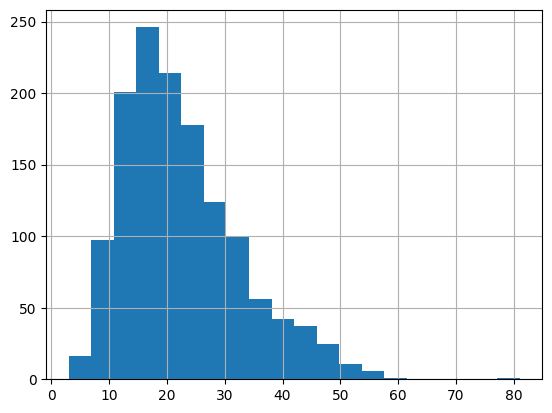

In [ ]:
# distribution of length of sentences
seq_len = pd.Series([len(i.split()) for i in train_texts])
seq_len.hist(bins = 20)

The median of the length of sentences in the training examples is around 25.

In [ ]:
max(seq_len)

81

The longest sentence has 81 words.

**Explore the frequency of special words in different classifications**

In [ ]:
def wordList(text_array):
  words_dict = {}
  for i in range(len(text_array)):
    s = text_array[i].split()
    for j in range(len(s)):
      words_dict[s[j]] = words_dict.get(s[j],0)+1
  words_i = sorted([(v, k) for k, v in words_dict.items()])[::-1]
  total = []
  for i in range(len(words_i)):
      if i >= 10:
        total.append(words_i[i][1])
        if len(total) == 30: break
  return total

df_train = pd.DataFrame({"sentence":train_texts,"label":train_labels})

l = []
for i in range(3):
  d_i = df_train[df_train["label"] == i]
  l_i = wordList(np.array(d_i["sentence"]))
  l.append(l_i)

l0 = []
l1 = []
l2 = []
for i in range(30):
  if l[0][i] not in l[1] and l[0][i] not in l[2]:
        l0.append(l[0][i])
  if l[1][i] not in l[0] and l[1][i] not in l[2]:
        l1.append(l[1][i])
  if l[2][i] not in l[0] and l[2][i] not in l[1]:
        l2.append(l[2][i])

print('negative: {}'.format(l0))
print('neutral: {}'.format(l1))
print('positive: {}'.format(l2))

negative: ['down', 'decreased', 'fell', 'Operating', '$', 'first', 'compared']
neutral: ['will', 'be', 'as', 'on', 'at', 'EUR', 'with', 'shares', 'Finland', 'was', ':', 'are', 'has', 'from', 'business', 'share', 'that', 'value', 'also']
positive: ['rose', 'The', 'up', '2010', 'increased', '-', 'Oyj']


Words like 'down', 'decreased' and 'fell' appear more frequently in the sentences with negative opinions, while words like 'rose', 'up' and 'increased' appear more frequently in the sentences with positive opinions.

# Basic Part

## Fine-tune only the classifier head.

**Import the distilbert model**

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
bert = TFDistilBertModel.from_pretrained("distilbert-base-uncased")

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_projector', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
class TextClassificationModel(keras.Model):
  def __init__(self, encoder, train_encoder=True):
    super(TextClassificationModel, self).__init__()
    self.encoder = encoder
    self.encoder.trainable = train_encoder
    self.dropout1 = layers.Dropout(0.1)
    self.dense1 = layers.Dense(20, activation="relu")
    self.dropout2 = layers.Dropout(0.1)
    self.dense2 = layers.Dense(3, activation='softmax')

  def call(self, input):
    x = self.encoder(input)
    x = x['last_hidden_state'][:, 0, :]
    x = self.dropout1(x)
    x = self.dense1(x)
    x = self.dropout2(x)
    x = self.dense2(x)
    return x

**Tokenization**

In [ ]:
train_encodings = tokenizer(list(train_texts), truncation=True, padding="max_length", max_length=128)
val_encodings = tokenizer(list(val_texts), truncation=True, padding="max_length", max_length=128)
test_encodings = tokenizer(list(test_texts), truncation=True, padding="max_length", max_length=128)

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
))

In [ ]:
text_classification_model = TextClassificationModel(bert, train_encoder=False)

In [ ]:
first_batch_outputs = text_classification_model(next(iter(train_dataset.batch(4))))

In [ ]:
def count_weights(weights_per_layer, prefix=None):
  count_weights = 0

  for layer, weights in enumerate(weights_per_layer):
    num_weights = np.prod(weights.shape)

    if prefix is not None:
      print(f"Trainable layer {layer} has {num_weights} weights")

    count_weights += num_weights

  return count_weights


def count_model_weights(model):
  all_weights = model.weights
  trainable_weights = model.trainable_weights

  num_layers = len( model.layers )

  out_prefix = "trainable" if len(trainable_weights) < 10 else None

  num_weights, num_trainable_weights = count_weights(all_weights, None), count_weights(trainable_weights, out_prefix)

  return num_weights, num_trainable_weights

In [ ]:
num_weights, num_trainable_weights = count_model_weights(text_classification_model)

print()
print(f"Total number of weights {num_weights:,}, number of trainable weights {num_trainable_weights:,}")

Trainable layer 0 has 15360 weights
Trainable layer 1 has 20 weights
Trainable layer 2 has 60 weights
Trainable layer 3 has 3 weights

Total number of weights 66,378,323, number of trainable weights 15,443


In [ ]:
# model summary
text_classification_model.summary()

Model: "text_classification_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tf_distil_bert_model (TFDis  multiple                 66362880  
 tilBertModel)                                                   
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
 dense (Dense)               multiple                  15380     
                                                                 
 dropout_20 (Dropout)        multiple                  0         
                                                                 
 dense_1 (Dense)             multiple                  63        
                                                                 
Total params: 66,378,323
Trainable params: 15,443
Non-trainable params: 66,362,880
________________________

In [ ]:
for i, layer in enumerate(text_classification_model.layers[-3:]):
  try:
    print(f"Layer {-3 + i}: {type(layer)} weights {layer.weights[0].shape}, biases {layer.weights[1].shape}")
  except Exception as e:
    pass

Layer -3: <class 'keras.layers.core.dense.Dense'> weights (768, 20), biases (20,)
Layer -1: <class 'keras.layers.core.dense.Dense'> weights (20, 3), biases (3,)


In [ ]:
def train_model(model, early_stopping_callback, train_dataset, val_dataset, batch_size=32, num_epochs=20):
  model.compile(
    tf.keras.optimizers.Adam(learning_rate=5e-5),
    "sparse_categorical_crossentropy",
    metrics=["accuracy"])

  history = model.fit(
    train_dataset.shuffle(1000).batch(batch_size),
    epochs=num_epochs,
    validation_data=val_dataset.batch(batch_size),
    callbacks=[early_stopping_callback]
  )

  return history

In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

**Train the model on the training set and validation set**

In [ ]:
train_model(text_classification_model, early_stopping_callback, train_dataset, val_dataset, 32, 20)

Epoch 1/20
43/43 [==============================] - 17s 118ms/step - loss: 1.0622 - accuracy: 0.4007 - val_loss: 0.9653 - val_accuracy: 0.5929
Epoch 2/20
43/43 [==============================] - 3s 73ms/step - loss: 0.9591 - accuracy: 0.5528 - val_loss: 0.9120 - val_accuracy: 0.6128
Epoch 3/20
43/43 [==============================] - 3s 73ms/step - loss: 0.9194 - accuracy: 0.5941 - val_loss: 0.8791 - val_accuracy: 0.6128
Epoch 4/20
43/43 [==============================] - 3s 75ms/step - loss: 0.8977 - accuracy: 0.5830 - val_loss: 0.8477 - val_accuracy: 0.6128
Epoch 5/20
43/43 [==============================] - 3s 72ms/step - loss: 0.8592 - accuracy: 0.6133 - val_loss: 0.8199 - val_accuracy: 0.6128
Epoch 6/20
43/43 [==============================] - 3s 74ms/step - loss: 0.8238 - accuracy: 0.6413 - val_loss: 0.7928 - val_accuracy: 0.6195
Epoch 7/20
43/43 [==============================] - 4s 88ms/step - loss: 0.8188 - accuracy: 0.6332 - val_loss: 0.7638 - val_accuracy: 0.6305
Epoch 8/20


**Evaluate the model on the test set**

In [ ]:
def evaluate_model(logits, labels):
  preds = np.argmax(logits, axis=1)
  acc = accuracy_score(labels, preds)
  print(f'Accuracy_score: {acc:.4f}')
  precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
  print(f"precision: {precision:.4f}\n"
        f"recall: {recall:.4f}\n"
        f"f1: {f1:.4f}")
  matrix = confusion_matrix(labels, preds)
  print('Confusion_matrix:','\n', matrix)
  return acc

In [ ]:
test_logits = text_classification_model.predict(test_dataset.batch(32))
test_preds = np.argmax(test_logits, axis=1)
evaluate_model(test_logits, test_labels)

15/15 [==============================] - 2s 46ms/step
Accuracy_score: 0.7898
precision: 0.7831
recall: 0.7898
f1: 0.7576
Confusion_matrix: 
 [[ 10  15  35]
 [  0 272   6]
 [  3  36  75]]


0.7898230088495575

The accuracy is 0.79 when we only fine-tune the classifier head.

## Fine-tune all weights.

In [ ]:
text_classification_model_all_weights = TextClassificationModel(bert, train_encoder=True)
train_model(text_classification_model_all_weights, early_stopping_callback, train_dataset, val_dataset, 32, 20)

Epoch 1/20
43/43 [==============================] - 35s 312ms/step - loss: 0.5107 - accuracy: 0.7815 - val_loss: 0.2648 - val_accuracy: 0.9027
Epoch 2/20
43/43 [==============================] - 10s 235ms/step - loss: 0.1458 - accuracy: 0.9469 - val_loss: 0.1547 - val_accuracy: 0.9491
Epoch 3/20
43/43 [==============================] - 9s 213ms/step - loss: 0.0606 - accuracy: 0.9779 - val_loss: 0.1462 - val_accuracy: 0.9602
Epoch 4/20
43/43 [==============================] - 8s 190ms/step - loss: 0.0435 - accuracy: 0.9875 - val_loss: 0.1479 - val_accuracy: 0.9469
Epoch 5/20
43/43 [==============================] - 8s 193ms/step - loss: 0.0249 - accuracy: 0.9934 - val_loss: 0.1232 - val_accuracy: 0.9602
Epoch 6/20
43/43 [==============================] - 8s 184ms/step - loss: 0.0106 - accuracy: 0.9956 - val_loss: 0.1368 - val_accuracy: 0.9602
Epoch 7/20
43/43 [==============================] - 8s 185ms/step - loss: 0.0240 - accuracy: 0.9941 - val_loss: 0.2205 - val_accuracy: 0.9358
Epoc

In [ ]:
test_logits = text_classification_model_all_weights.predict(test_dataset.batch(32))
test_preds = np.argmax(test_logits, axis=1)
evaluate_model(test_logits, test_labels)

15/15 [==============================] - 2s 47ms/step
Accuracy_score: 0.9425
precision: 0.9464
recall: 0.9425
f1: 0.9435
Confusion_matrix: 
 [[ 58   0   2]
 [  4 263  11]
 [  7   2 105]]


0.9424778761061947

The accuracy is 0.94 when we fine-tune all weights rather than only fine-tune the classifier head, which improved the result by around 22%.

# Extra Part

## Create (and fit the model with) a TensorFlow Dataset (TFDS)

In [ ]:
dataset_name = "financial_phrasebank"
subset_name = 'sentences_allagree'
dataset = load_dataset(dataset_name, subset_name)
tokenized = dataset.map(lambda x: tokenizer(x["sentence"]))
collator = DataCollatorWithPadding(return_tensors="tf", tokenizer=tokenizer)

tfdataset = tokenized['train'].to_tf_dataset(
    columns=["input_ids", "attention_mask"],
    label_cols=["labels"],
    batch_size=32,
    shuffle=True,
    collate_fn=collator,
)

  0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:388: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [ ]:
text_classification_model = TextClassificationModel(bert, train_encoder=False)

dataset_size = len(tfdataset)
train_size = int(0.64 * dataset_size)
val_size = int(0.2 * dataset_size)

tf_train_dataset = tfdataset.take(train_size)
tf_val_dataset = tfdataset.skip(train_size).take(val_size)
tf_test_dataset = tfdataset.skip(train_size).skip(val_size)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [ ]:
def train_tf_model(model, early_stopping_callback, tf_train_dataset, tf_val_dataset, batch_size=32, num_epochs=20):
  model.compile(
    tf.keras.optimizers.Adam(learning_rate=5e-5),
    "sparse_categorical_crossentropy",
    metrics=["accuracy"]
  )
  history = text_classification_model.fit(
  tf_train_dataset,
  epochs=20,
  validation_data=tf_val_dataset,
  callbacks=[early_stopping_callback]
  )

In [ ]:
train_tf_model(text_classification_model, early_stopping_callback, tf_train_dataset, tf_val_dataset, 32, 20)

Epoch 1/20
45/45 [==============================] - 12s 97ms/step - loss: 0.8741 - accuracy: 0.6271 - val_loss: 0.5490 - val_accuracy: 0.9554
Epoch 2/20
45/45 [==============================] - 3s 57ms/step - loss: 0.4228 - accuracy: 0.9431 - val_loss: 0.2593 - val_accuracy: 0.9665
Epoch 3/20
45/45 [==============================] - 2s 50ms/step - loss: 0.2197 - accuracy: 0.9778 - val_loss: 0.1261 - val_accuracy: 0.9844
Epoch 4/20
45/45 [==============================] - 2s 48ms/step - loss: 0.1556 - accuracy: 0.9792 - val_loss: 0.0889 - val_accuracy: 0.9799
Epoch 5/20
45/45 [==============================] - 2s 52ms/step - loss: 0.1285 - accuracy: 0.9729 - val_loss: 0.0664 - val_accuracy: 0.9888
Epoch 6/20
45/45 [==============================] - 2s 51ms/step - loss: 0.1099 - accuracy: 0.9785 - val_loss: 0.0663 - val_accuracy: 0.9821
Epoch 7/20
45/45 [==============================] - 2s 45ms/step - loss: 0.0929 - accuracy: 0.9771 - val_loss: 0.0790 - val_accuracy: 0.9754
Epoch 8/20
4

## Use own classifier head

From the sample code, the classifier head seems not very reasonable since the classification only makes use of the first embedding of every sentence to make the decision.

While the information of following words are taken into consideration because of the mechanism of attention, it seems better to make full use of all the information in the embeddings.

Here I come up with two ideas.
The first one is to use the average value of all embeddings, which is known as "sentence embedding".
The second idea is to feed the 3-d embeddings (batch_size, sequence length, hiddden_size) to an LSTM network to make full use of all the information.

### Sentence Embedding



In [ ]:
class SentenceEmbedding(keras.Model):
  def __init__(self, encoder, train_encoder=True):
    super(SentenceEmbedding, self).__init__()
    self.encoder = encoder
    self.encoder.trainable = train_encoder
    self.dropout1 = layers.Dropout(0.1)
    self.dense1 = layers.Dense(64, activation="relu")
    self.dropout2 = layers.Dropout(0.1)
    self.dense2 = layers.Dense(3, activation='softmax')

  def call(self, input):
    x = self.encoder(input)
    # sentence embedding
    x = tf.reduce_mean(x['last_hidden_state'], axis=1)
    x = self.dropout1(x)
    x = self.dense1(x)
    x = self.dropout2(x)
    x = self.dense2(x)
    return x

In [ ]:
sentence_embedding = SentenceEmbedding(bert, train_encoder=False)
train_model(sentence_embedding, early_stopping_callback, train_dataset, val_dataset, 32, 20)

Epoch 1/20
43/43 [==============================] - 11s 115ms/step - loss: 0.8022 - accuracy: 0.7151 - val_loss: 0.5123 - val_accuracy: 0.8429
Epoch 2/20
43/43 [==============================] - 3s 76ms/step - loss: 0.3493 - accuracy: 0.9188 - val_loss: 0.2753 - val_accuracy: 0.9292
Epoch 3/20
43/43 [==============================] - 3s 73ms/step - loss: 0.1825 - accuracy: 0.9705 - val_loss: 0.1862 - val_accuracy: 0.9491
Epoch 4/20
43/43 [==============================] - 3s 75ms/step - loss: 0.1116 - accuracy: 0.9838 - val_loss: 0.1455 - val_accuracy: 0.9624
Epoch 5/20
43/43 [==============================] - 3s 74ms/step - loss: 0.0752 - accuracy: 0.9904 - val_loss: 0.1255 - val_accuracy: 0.9624
Epoch 6/20
43/43 [==============================] - 3s 75ms/step - loss: 0.0616 - accuracy: 0.9926 - val_loss: 0.1133 - val_accuracy: 0.9646
Epoch 7/20
43/43 [==============================] - 3s 79ms/step - loss: 0.0468 - accuracy: 0.9963 - val_loss: 0.1060 - val_accuracy: 0.9624
Epoch 8/20


In [ ]:
test_logits = sentence_embedding.predict(test_dataset.batch(32))
test_preds = np.argmax(test_logits, axis=1)
evaluate_model(test_logits, test_labels)
test_preds

15/15 [==============================] - 2s 47ms/step
Accuracy_score: 0.9447
precision: 0.9470
recall: 0.9447
f1: 0.9451
Confusion_matrix: 
 [[ 59   1   0]
 [  5 264   9]
 [  5   5 104]]


array([1, 2, 1, 1, 2, 2, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       2, 2, 0, 1, 1, 0, 1, 1, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0, 1, 1, 0, 1,
       2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 0, 0, 2, 0, 1, 0, 1, 1, 2, 1, 2, 1,
       2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 0, 1, 2, 1, 0, 1, 2, 1, 1, 2, 0, 2,
       2, 1, 0, 1, 2, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 0, 1, 2, 1, 2, 1, 2,
       1, 0, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1,
       1, 0, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 2, 2,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1,
       1, 0, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 0, 1, 1, 0, 1, 2, 0, 2, 1, 1, 1, 1, 0, 2, 1, 2,
       2, 2, 0, 2, 1, 2, 2, 2, 1, 1, 1, 1, 0, 1, 2, 1, 2, 1, 1, 0, 2, 1,
       2, 0, 2, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1,
       1, 2, 1, 1, 2, 1, 0, 1, 0, 2, 2, 1, 2, 0, 2, 2, 1, 0, 1, 1, 1, 2,
       2, 0, 2, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1,

The result is close to the previous one when we use the original classifier head.

### LSTM

In [ ]:
class Embedding_LSTM(keras.Model):
  def __init__(self, encoder, train_encoder=True):
    super(Embedding_LSTM, self).__init__()
    self.encoder = encoder
    self.encoder.trainable = train_encoder
    self.lstm = layers.LSTM(32)
    self.dropout1 = layers.Dropout(0.1)
    self.dense1 = layers.Dense(64, activation="relu")
    self.dropout2 = layers.Dropout(0.1)
    self.dense2 = layers.Dense(3, activation='softmax')

  def call(self, input):
    x = self.encoder(input)
    x = self.lstm(x['last_hidden_state'])
    x = self.dropout1(x)
    x = self.dense1(x)
    x = self.dropout2(x)
    x = self.dense2(x)
    return x

In [ ]:
embedding_lstm = Embedding_LSTM(bert, train_encoder=False)
train_model(embedding_lstm, early_stopping_callback, train_dataset, val_dataset, 32, 20)

Epoch 1/20
43/43 [==============================] - 15s 126ms/step - loss: 0.7539 - accuracy: 0.8531 - val_loss: 0.5835 - val_accuracy: 0.9204
Epoch 2/20
43/43 [==============================] - 3s 78ms/step - loss: 0.4578 - accuracy: 0.9638 - val_loss: 0.3925 - val_accuracy: 0.9336
Epoch 3/20
43/43 [==============================] - 3s 79ms/step - loss: 0.2938 - accuracy: 0.9779 - val_loss: 0.2843 - val_accuracy: 0.9491
Epoch 4/20
43/43 [==============================] - 3s 81ms/step - loss: 0.2015 - accuracy: 0.9889 - val_loss: 0.2235 - val_accuracy: 0.9580
Epoch 5/20
43/43 [==============================] - 3s 77ms/step - loss: 0.1455 - accuracy: 0.9897 - val_loss: 0.1856 - val_accuracy: 0.9624
Epoch 6/20
43/43 [==============================] - 3s 78ms/step - loss: 0.1090 - accuracy: 0.9956 - val_loss: 0.1627 - val_accuracy: 0.9624
Epoch 7/20
43/43 [==============================] - 3s 80ms/step - loss: 0.0824 - accuracy: 0.9970 - val_loss: 0.1490 - val_accuracy: 0.9646
Epoch 8/20


In [ ]:
test_logits = embedding_lstm.predict(test_dataset.batch(32))
test_preds = np.argmax(test_logits, axis=1)
evaluate_model(test_logits, test_labels)
test_preds

15/15 [==============================] - 2s 48ms/step
Accuracy_score: 0.9491
precision: 0.9524
recall: 0.9491
f1: 0.9498
Confusion_matrix: 
 [[ 59   1   0]
 [  4 267   7]
 [  8   3 103]]


array([1, 2, 1, 1, 2, 2, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 2, 0, 1, 1, 0, 1, 1, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0, 1, 1, 0, 1,
       2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 0, 0, 2, 0, 1, 0, 1, 1, 2, 1, 2, 1,
       2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 0, 1, 2, 1, 0, 1, 2, 1, 1, 2, 0, 2,
       2, 1, 0, 1, 2, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 0, 1, 2, 1, 2, 1, 2,
       1, 0, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 0, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 2, 2,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1,
       1, 0, 1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 0, 1, 1, 0, 1, 2, 0, 2, 1, 1, 1, 1, 0, 2, 1, 2,
       2, 2, 0, 2, 1, 2, 2, 2, 1, 1, 1, 1, 0, 1, 2, 1, 2, 1, 1, 0, 2, 1,
       2, 0, 2, 1, 1, 1, 0, 0, 1, 2, 0, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1,
       1, 2, 1, 1, 2, 1, 0, 1, 0, 2, 2, 1, 2, 0, 2, 2, 1, 0, 1, 1, 1, 2,
       2, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1,

The result is close to the previous one when we use the original classifier head.

From the above results, changing the classifier head seems to has no obvious impact on the performance of the model.

## Use different "flavors" of the dataset

**Load three datasets with different percentages of agree**

In [ ]:
def get_data(subset_name, tokenizer):
  dataset_name = "financial_phrasebank"
  dataset = load_dataset(dataset_name, subset_name)

  train_texts, train_labels = dataset['train']["sentence"], dataset['train']["label"]
  train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.20, stratify=train_labels, random_state=42)
  train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size=0.20, stratify=train_labels, random_state=42)

  train_encodings = tokenizer(list(train_texts), truncation=True, padding="max_length", max_length=128)
  val_encodings = tokenizer(list(val_texts), truncation=True, padding="max_length", max_length=128)
  test_encodings = tokenizer(list(test_texts), truncation=True, padding="max_length", max_length=128)

  train_dataset = tf.data.Dataset.from_tensor_slices((
      dict(train_encodings),
      train_labels
  ))
  val_dataset = tf.data.Dataset.from_tensor_slices((
      dict(val_encodings),
      val_labels
  ))
  test_dataset = tf.data.Dataset.from_tensor_slices((
      dict(test_encodings),
      test_labels
  ))

  return train_dataset, val_dataset, test_dataset, test_labels

In [ ]:
subset_name1 = 'sentences_75agree'
subset_name2 = 'sentences_66agree'
subset_name3 = 'sentences_50agree'

train_dataset1, val_dataset1, test_dataset1, test_labels1 = get_data(subset_name1, tokenizer)
train_dataset2, val_dataset2, test_dataset2, test_labels2 = get_data(subset_name2, tokenizer)
train_dataset3, val_dataset3, test_dataset3, test_labels3 = get_data(subset_name3, tokenizer)

Generating train split:   0%|          | 0/3453 [00:00<?, ? examples/s]

Dataset financial_phrasebank downloaded and prepared to /root/.cache/huggingface/datasets/financial_phrasebank/sentences_75agree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/4217 [00:00<?, ? examples/s]

Dataset financial_phrasebank downloaded and prepared to /root/.cache/huggingface/datasets/financial_phrasebank/sentences_66agree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/4846 [00:00<?, ? examples/s]

Dataset financial_phrasebank downloaded and prepared to /root/.cache/huggingface/datasets/financial_phrasebank/sentences_50agree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

### sentences_75agree

In [ ]:
embedding_lstm1 = Embedding_LSTM(bert, train_encoder=True)
train_model(embedding_lstm1, early_stopping_callback, train_dataset1, val_dataset1, 32, 50)

test_logits = embedding_lstm1.predict(test_dataset1.batch(32))
test_preds = np.argmax(test_logits, axis=1)
evaluate_model(test_logits, test_labels1)
test_preds

Epoch 1/50
70/70 [==============================] - 40s 257ms/step - loss: 0.3769 - accuracy: 0.9040 - val_loss: 0.2394 - val_accuracy: 0.9247
Epoch 2/50
70/70 [==============================] - 13s 193ms/step - loss: 0.1971 - accuracy: 0.9565 - val_loss: 0.2261 - val_accuracy: 0.9334
Epoch 3/50
70/70 [==============================] - 13s 192ms/step - loss: 0.1302 - accuracy: 0.9746 - val_loss: 0.1858 - val_accuracy: 0.9537
Epoch 4/50
70/70 [==============================] - 12s 175ms/step - loss: 0.1178 - accuracy: 0.9737 - val_loss: 0.2014 - val_accuracy: 0.9450
Epoch 5/50
70/70 [==============================] - 12s 171ms/step - loss: 0.0835 - accuracy: 0.9860 - val_loss: 0.1891 - val_accuracy: 0.9479
Epoch 6/50
70/70 [==============================] - 12s 165ms/step - loss: 0.0731 - accuracy: 0.9873 - val_loss: 0.1915 - val_accuracy: 0.9436
Epoch 7/50
70/70 [==============================] - 11s 164ms/step - loss: 0.0693 - accuracy: 0.9869 - val_loss: 0.1770 - val_accuracy: 0.9465

array([1, 1, 1, 0, 0, 2, 0, 1, 1, 0, 2, 1, 0, 0, 0, 2, 1, 1, 2, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 2, 0, 2, 1, 2, 1, 2, 0, 1, 1, 0, 1, 1, 1, 1,
       2, 2, 2, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 2, 1, 1, 0, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 0, 1,
       1, 1, 2, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1,
       1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 0, 1, 1, 2,
       0, 1, 1, 1, 1, 2, 1, 1, 2, 1, 0, 2, 2, 0, 1, 1, 1, 1, 1, 2, 0, 2,
       1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 2, 1, 1, 2, 2, 2,
       1, 2, 2, 2, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 1, 1, 1, 1, 2, 0, 0, 1,
       0, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 2,
       2, 0, 1, 0, 0, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1,
       1, 1, 2, 1, 2, 0, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 0, 2, 0,
       1, 2, 1, 2, 0, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2,
       1, 2, 0, 1, 1, 1, 0, 1, 2, 1, 1, 2, 1, 2, 1,

The accuracy on 75agree dataset is 0.93, which is 0.1 points lower than the allagree dataset.

### sentences_66agree

In [ ]:
embedding_lstm2 = Embedding_LSTM(bert, train_encoder=True)
train_model(embedding_lstm2, early_stopping_callback, train_dataset2, val_dataset2, 32, 50)

test_logits = embedding_lstm2.predict(test_dataset2.batch(32))
test_preds = np.argmax(test_logits, axis=1)
evaluate_model(test_logits, test_labels2)
test_preds

Epoch 1/50
85/85 [==============================] - 43s 241ms/step - loss: 0.4800 - accuracy: 0.8888 - val_loss: 0.3305 - val_accuracy: 0.9100
Epoch 2/50
85/85 [==============================] - 16s 190ms/step - loss: 0.2744 - accuracy: 0.9403 - val_loss: 0.2943 - val_accuracy: 0.9182
Epoch 3/50
85/85 [==============================] - 15s 175ms/step - loss: 0.1981 - accuracy: 0.9548 - val_loss: 0.3111 - val_accuracy: 0.9005
Epoch 4/50
85/85 [==============================] - 14s 162ms/step - loss: 0.1564 - accuracy: 0.9681 - val_loss: 0.3118 - val_accuracy: 0.9028
Epoch 5/50
85/85 [==============================] - 14s 160ms/step - loss: 0.1170 - accuracy: 0.9770 - val_loss: 0.3060 - val_accuracy: 0.9159
Epoch 6/50
85/85 [==============================] - 14s 161ms/step - loss: 0.0829 - accuracy: 0.9863 - val_loss: 0.3330 - val_accuracy: 0.9076
Epoch 7/50
22/22 [==============================] - 3s 49ms/step
Accuracy_score: 0.9156
precision: 0.9152
recall: 0.9156
f1: 0.9153
Confusion_

array([1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 0, 2, 2, 0, 0, 2, 1, 2,
       1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 0, 1, 1,
       1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 0, 1, 2, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 2, 1, 1, 1, 0, 0, 1, 2, 1, 1,
       1, 1, 1, 0, 2, 1, 1, 1, 0, 1, 1, 1, 2, 1, 2, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1,
       0, 1, 1, 1, 1, 2, 1, 1, 2, 1, 0, 1, 1, 0, 0, 2, 1, 1, 0, 1, 1, 1,
       2, 1, 1, 2, 2, 1, 2, 2, 2, 1, 1, 1, 0, 2, 1, 1, 2, 1, 1, 1, 2, 1,
       1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 0, 1, 2, 0, 1, 1, 2,
       1, 1, 1, 2, 2, 1, 0, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       0, 2, 2, 0, 1, 1, 2, 1, 1, 1, 2, 0, 2, 1, 2, 1, 2, 1, 1, 2, 0, 1,
       1, 2, 1, 1, 1, 1, 1, 2, 0, 0, 2, 1, 0, 2, 2,

The accuracy on 66agree dataset is 0.91, which is 0.3 points lower than the allagree dataset.

### sentences_50agree

In [ ]:
embedding_lstm3 = Embedding_LSTM(bert, train_encoder=True)
train_model(embedding_lstm3, early_stopping_callback, train_dataset3, val_dataset3, 32, 50)

test_logits = embedding_lstm3.predict(test_dataset3.batch(32))
test_preds = np.argmax(test_logits, axis=1)
evaluate_model(test_logits, test_labels3)
test_preds

Epoch 1/50
97/97 [==============================] - 47s 237ms/step - loss: 0.2395 - accuracy: 0.9526 - val_loss: 0.3823 - val_accuracy: 0.8948
Epoch 2/50
97/97 [==============================] - 17s 175ms/step - loss: 0.1498 - accuracy: 0.9655 - val_loss: 0.4399 - val_accuracy: 0.8711
Epoch 3/50
97/97 [==============================] - 18s 183ms/step - loss: 0.1202 - accuracy: 0.9768 - val_loss: 0.4619 - val_accuracy: 0.8866
Epoch 4/50
97/97 [==============================] - 16s 162ms/step - loss: 0.1258 - accuracy: 0.9713 - val_loss: 0.4275 - val_accuracy: 0.8784
Epoch 5/50
97/97 [==============================] - 16s 163ms/step - loss: 0.1122 - accuracy: 0.9761 - val_loss: 0.4421 - val_accuracy: 0.8918
Epoch 6/50
25/25 [==============================] - 3s 48ms/step
Accuracy_score: 0.8892
precision: 0.8894
recall: 0.8892
f1: 0.8888
Confusion_matrix: 
 [[ 89   6   2]
 [ 11 424  26]
 [  7  34 177]]


array([1, 1, 2, 2, 2, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 2, 1,
       2, 1, 2, 1, 1, 2, 0, 1, 2, 0, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 0,
       1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 0, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1,
       1, 1, 2, 2, 1, 0, 0, 0, 2, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1,
       1, 1, 1, 0, 2, 1, 0, 1, 1, 0, 2, 1, 0, 1, 1, 1, 1, 2, 2, 0, 2, 2,
       1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 0, 2, 1, 0, 0, 1, 2, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 2, 2, 1, 1, 0, 1, 1, 1, 1, 2, 1, 0, 0, 2, 1, 2, 1,
       0, 0, 1, 2, 2, 1, 1, 2, 0, 1, 1, 1, 0, 1, 1, 2, 1, 1, 2, 0, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1,
       1, 2, 1, 0, 2, 2, 1, 2, 1, 1, 1, 0, 2, 1, 2, 1, 1, 1, 0, 2, 1, 1,
       2, 0, 2, 0, 0, 2, 1, 1, 1, 2, 2, 1, 0, 1, 2, 1, 0, 1, 2, 2, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 0,

The accuracy on 50agree dataset is 0.89, which is 0.6 points lower than the allagree dataset.

From above results, we can conclude that the prediction accuracy tend to decrease with the percentage of agreement to the classification decreasing.

## Address Imbalanced Data issues

From the data loading part, we can find the proportion of the three labels is not on the same level, with the 'neutral' label taking more than 60% of all the samples. Hence, more weights are given to the classes with lower proportions.

In [ ]:
def train_model_imbalanced_data(model, early_stopping_callback, train_dataset, val_dataset, train_labels,
                                batch_size=32, num_epochs=20):
  model.compile(
    tf.keras.optimizers.Adam(learning_rate=5e-5),
    "sparse_categorical_crossentropy",
    metrics=["accuracy"],
    sample_weight_mode=compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
  )

  history = model.fit(
    train_dataset.shuffle(1000).batch(batch_size),
    epochs=num_epochs,
    validation_data=val_dataset.batch(batch_size),
    callbacks=[early_stopping_callback]
  )

  return history

In [ ]:
embedding_lstm = Embedding_LSTM(bert, train_encoder=True)

train_model_imbalanced_data(embedding_lstm, early_stopping_callback, train_dataset, val_dataset, train_labels, 32, 50)

test_logits = embedding_lstm.predict(test_dataset.batch(32))
test_preds = np.argmax(test_logits, axis=1)
evaluate_model(test_logits, test_labels)
test_preds

Epoch 1/50
43/43 [==============================] - 34s 272ms/step - loss: 0.3605 - accuracy: 0.9446 - val_loss: 0.1359 - val_accuracy: 0.9912
Epoch 2/50
43/43 [==============================] - 9s 210ms/step - loss: 0.1206 - accuracy: 0.9919 - val_loss: 0.0866 - val_accuracy: 0.9934
Epoch 3/50
43/43 [==============================] - 9s 204ms/step - loss: 0.0971 - accuracy: 0.9889 - val_loss: 0.0712 - val_accuracy: 0.9912
Epoch 4/50
43/43 [==============================] - 8s 193ms/step - loss: 0.0603 - accuracy: 0.9970 - val_loss: 0.0595 - val_accuracy: 0.9912
Epoch 5/50
43/43 [==============================] - 8s 179ms/step - loss: 0.0486 - accuracy: 0.9970 - val_loss: 0.0479 - val_accuracy: 0.9934
Epoch 6/50
43/43 [==============================] - 7s 175ms/step - loss: 0.0397 - accuracy: 0.9985 - val_loss: 0.0539 - val_accuracy: 0.9912
Epoch 7/50
43/43 [==============================] - 7s 169ms/step - loss: 0.0345 - accuracy: 0.9985 - val_loss: 0.0503 - val_accuracy: 0.9934
Epoch

array([1, 2, 1, 1, 2, 2, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       2, 2, 2, 1, 1, 0, 1, 1, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0, 1, 1, 0, 1,
       2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 0, 2, 0, 1, 0, 1, 1, 2, 1, 2, 1,
       1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 0, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2,
       2, 1, 1, 1, 2, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 0, 1, 2, 1, 2, 1, 2,
       1, 0, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 0, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 2, 2,
       1, 0, 1, 1, 1, 0, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1,
       1, 0, 1, 1, 1, 2, 2, 1, 0, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 2, 0, 2, 1, 1, 1, 1, 0, 2, 1, 2,
       2, 2, 0, 2, 1, 2, 2, 2, 1, 1, 1, 1, 0, 1, 2, 1, 2, 1, 1, 0, 2, 1,
       2, 0, 2, 1, 1, 1, 0, 0, 1, 2, 0, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1,
       1, 2, 1, 1, 2, 1, 0, 1, 0, 2, 1, 1, 2, 0, 2, 2, 1, 0, 1, 1, 1, 2,
       2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 2, 1,

The accuracy is improved by 0.4 after addressing data imbalance.

## Experiment with different Pre-Trained models

### Bert-base-uncased

In [ ]:
from transformers import BertTokenizerFast,TFBertModel

tokenizer1 = BertTokenizerFast.from_pretrained('bert-base-uncased')
bert1 = TFBertModel.from_pretrained("bert-base-uncased")
embedding_lstm1 = Embedding_LSTM(bert1)

train_dataset, val_dataset, test_dataset, test_labels = get_data("sentences_allagree", tokenizer1)

train_model_imbalanced_data(embedding_lstm1, early_stopping_callback, train_dataset, val_dataset, train_labels, 32, 50)

test_logits = embedding_lstm1.predict(test_dataset.batch(32))
test_preds = np.argmax(test_logits, axis=1)
evaluate_model(test_logits, test_labels)
test_preds

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/50


46/46 [==============================] - 66s 421ms/step - loss: 0.5499 - accuracy: 0.8080 - val_loss: 0.3357 - val_accuracy: 0.9051
Epoch 2/50
46/46 [==============================] - 15s 333ms/step - loss: 0.2540 - accuracy: 0.9413 - val_loss: 0.2113 - val_accuracy: 0.9470
Epoch 3/50
46/46 [==============================] - 15s 329ms/step - loss: 0.1457 - accuracy: 0.9731 - val_loss: 0.1555 - val_accuracy: 0.9603
Epoch 4/50
46/46 [==============================] - 15s 325ms/step - loss: 0.0981 - accuracy: 0.9834 - val_loss: 0.1182 - val_accuracy: 0.9779
Epoch 5/50
46/46 [==============================] - 14s 309ms/step - loss: 0.0735 - accuracy: 0.9890 - val_loss: 0.1433 - val_accuracy: 0.9625
Epoch 6/50
46/46 [==============================] - 14s 313ms/step - loss: 0.0571 - accuracy: 0.9917 - val_loss: 0.1415 - val_accuracy: 0.9669
Epoch 7/50
46/46 [==============================] - 14s 310ms/step - loss: 0.0355 - accuracy: 0.9986 - val_loss: 0.1534 - val_accuracy: 0.9669
Epoch 8/50

array([1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 2,
       0, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 0, 0, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2,
       2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 2, 1, 1,
       1, 0, 2, 0, 1, 1, 1, 1, 1, 2, 2, 2, 0, 0, 2, 1, 1, 1, 1, 1, 2, 1,
       1, 0, 0, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 0, 1, 2, 0, 2, 0, 0,
       1, 2, 1, 1, 1, 0, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0,
       1, 2, 0, 2, 2, 0, 2, 1, 1, 1, 2, 2, 0, 2, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 2, 1, 2, 1, 2, 1, 1, 1, 0, 2, 0,
       1, 2, 0, 1, 1, 1, 1, 2, 0, 2, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 2, 2, 1, 1, 0, 1, 1, 0, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 0,
       2, 1, 1, 0, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 0,

### Bert-base-cased

In [ ]:
tokenizer2 = BertTokenizerFast.from_pretrained("bert-base-cased")
bert2 = TFBertModel.from_pretrained("bert-base-cased")
embedding_lstm2 = Embedding_LSTM(bert2)

train_dataset, val_dataset, test_dataset, test_labels = get_data("sentences_allagree", tokenizer2)

train_model_imbalanced_data(embedding_lstm2, early_stopping_callback, train_dataset, val_dataset, train_labels, 32, 20)

test_logits = embedding_lstm2.predict(test_dataset.batch(32))
test_preds = np.argmax(test_logits, axis=1)
evaluate_model(test_logits, test_labels)
test_preds

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/20


46/46 [==============================] - 64s 474ms/step - loss: 0.5255 - accuracy: 0.8039 - val_loss: 0.2702 - val_accuracy: 0.9139
Epoch 2/20
46/46 [==============================] - 16s 353ms/step - loss: 0.1845 - accuracy: 0.9530 - val_loss: 0.1516 - val_accuracy: 0.9603
Epoch 3/20
46/46 [==============================] - 15s 333ms/step - loss: 0.1128 - accuracy: 0.9758 - val_loss: 0.1750 - val_accuracy: 0.9603
Epoch 4/20
46/46 [==============================] - 16s 352ms/step - loss: 0.1012 - accuracy: 0.9807 - val_loss: 0.1944 - val_accuracy: 0.9492
Epoch 5/20
46/46 [==============================] - 15s 317ms/step - loss: 0.0961 - accuracy: 0.9800 - val_loss: 0.1784 - val_accuracy: 0.9426
Epoch 6/20
46/46 [==============================] - 15s 334ms/step - loss: 0.0923 - accuracy: 0.9731 - val_loss: 0.1171 - val_accuracy: 0.9669
Epoch 7/20
46/46 [==============================] - 15s 321ms/step - loss: 0.0547 - accuracy: 0.9890 - val_loss: 0.1031 - val_accuracy: 0.9801
Epoch 8/20

array([1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 2,
       0, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 0, 2, 1, 1, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 0, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2,
       2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 2, 1, 1,
       1, 0, 2, 0, 1, 1, 1, 1, 1, 2, 2, 2, 0, 0, 2, 1, 1, 1, 1, 1, 2, 1,
       1, 0, 0, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 0, 0,
       1, 2, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0,
       1, 2, 0, 2, 2, 0, 2, 1, 1, 1, 2, 2, 0, 2, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 2, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 2, 2, 2, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 2, 1, 2, 1, 2, 1, 1, 1, 0, 2, 0,
       1, 2, 0, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 2, 2, 1, 1, 0, 1, 1, 0, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 0,
       2, 1, 1, 0, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 0,

The performances of bert-base-uncased and bert-based-cased are similar with distilbert. Bert-based-cased is slightly worse than the other two, which may suggest that the 'case' is not important for our task.

## In-context learning

In [ ]:
dataset_name = "financial_phrasebank"
dataset = load_dataset(dataset_name, "sentences_allagree")

train_texts, train_labels = dataset['train']["sentence"], dataset['train']["label"]
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.20, stratify=train_labels, random_state=42)
train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size=0.20, stratify=train_labels, random_state=42)

train_encodings = tokenizer(list(train_texts), truncation=True, padding="max_length", max_length=128)
val_encodings = tokenizer(list(val_texts), truncation=True, padding="max_length", max_length=128)
test_encodings = tokenizer(list(test_texts), truncation=True, padding="max_length", max_length=128)

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
))

  0%|          | 0/1 [00:00<?, ?it/s]

From the EDA part, some words are found to appear more times in the examples with certain labels. Hence, I use these words here to filter out a part of the test set to do the few-shot training.

In [ ]:
print('length of the entire testset:', len(test_texts))
indices = []
for i, text in enumerate(test_texts):
  for key_word in ['rose', 'fell', 'up', 'increased', 'decreased','down']:
    if key_word in text.split():
      indices.append(i)
print('Few-shot samples length:', len(indices))
print(' ')

few_shot_texts = []
few_shot_labels = []
for idx in indices:
  few_shot_texts.append(test_texts[idx])
  few_shot_labels.append(test_labels[idx])

few_shot_encodings = tokenizer(list(few_shot_texts), truncation=True, padding="max_length", max_length=128)
test_encodings = tokenizer(list(test_texts), truncation=True, padding="max_length", max_length=128)

few_shot_dataset = tf.data.Dataset.from_tensor_slices((
    dict(few_shot_encodings),
    few_shot_labels
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
))

embedding_lstm = Embedding_LSTM(bert, train_encoder=True)

train_model(embedding_lstm, early_stopping_callback, few_shot_dataset, test_dataset, 10, 50)

test_logits = embedding_lstm.predict(test_dataset.batch(10))
test_preds = np.argmax(test_logits, axis=1)
evaluate_model(test_logits, test_labels)
test_preds

length of the entire testset: 363
Few-shot samples length: 64
 
Epoch 1/50
7/7 [==============================] - 30s 734ms/step - loss: 0.8098 - accuracy: 0.7188 - val_loss: 0.5095 - val_accuracy: 0.9917
Epoch 2/50
7/7 [==============================] - 3s 400ms/step - loss: 0.5324 - accuracy: 0.9688 - val_loss: 0.3744 - val_accuracy: 0.9917
Epoch 3/50
7/7 [==============================] - 2s 369ms/step - loss: 0.4026 - accuracy: 0.9688 - val_loss: 0.3037 - val_accuracy: 0.9917
Epoch 4/50
7/7 [==============================] - 2s 347ms/step - loss: 0.2925 - accuracy: 0.9844 - val_loss: 0.2794 - val_accuracy: 0.9890
Epoch 5/50
7/7 [==============================] - 2s 376ms/step - loss: 0.2691 - accuracy: 0.9844 - val_loss: 0.2394 - val_accuracy: 0.9862
Epoch 6/50
7/7 [==============================] - 2s 350ms/step - loss: 0.2408 - accuracy: 0.9844 - val_loss: 0.2340 - val_accuracy: 0.9890
Epoch 7/50
7/7 [==============================] - 2s 330ms/step - loss: 0.2165 - accuracy: 0.98

array([1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 2,
       0, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 0, 2, 1, 1, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 0, 0, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2,
       2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 2, 1, 1,
       1, 0, 2, 0, 1, 1, 1, 1, 1, 2, 2, 2, 0, 0, 2, 1, 1, 1, 1, 1, 2, 1,
       1, 0, 0, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 0, 1, 0, 0, 2, 0, 0,
       1, 2, 1, 1, 1, 0, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0,
       1, 2, 0, 2, 2, 0, 2, 1, 1, 1, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 0, 1,
       1, 1, 2, 1, 1, 1, 2, 0, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 2, 2, 2, 1, 2, 1, 1, 1, 0, 2, 0,
       1, 2, 0, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 2, 2, 1, 1, 0, 1, 1, 0, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 0,
       2, 1, 1, 0, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 0,

The accuracy is 0.99 after applying in-context learning, which means in-context learning could effectively improve our results.